## Settings

In [295]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import lightgbm as lgb

from sklearn.metrics import classification_report

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Reading and Observing Train and Test Datasets

In [296]:
train = pd.read_csv('/content/drive/MyDrive/JOB-A-THON - September 2021/TRAIN.csv') #reading our train dataset from google drive
train.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [297]:
train.tail() #observing last rows

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
188335,T1188336,149,S2,L3,R2,2019-05-31,1,Yes,51,37272.00
188336,T1188337,153,S4,L2,R1,2019-05-31,1,No,90,54572.64
188337,T1188338,154,S1,L3,R2,2019-05-31,1,No,56,31624.56
188338,T1188339,155,S3,L1,R2,2019-05-31,1,Yes,70,49162.41
188339,T1188340,152,S2,L1,R1,2019-05-31,1,No,47,37977.00


In [298]:
train.shape #checking size of dataset

(188340, 10)

In [299]:
test = pd.read_csv('/content/drive/MyDrive/JOB-A-THON - September 2021/TEST_FINAL.csv') #reading test dataset
test.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount
0,T1188341,171,S4,L2,R3,2019-06-01,0,No
1,T1188342,172,S1,L1,R1,2019-06-01,0,No
2,T1188343,173,S4,L2,R1,2019-06-01,0,No
3,T1188344,174,S1,L1,R4,2019-06-01,0,No
4,T1188345,170,S1,L1,R2,2019-06-01,0,No


In [300]:
test.shape

(22265, 8)

In [301]:
(train.isnull().sum()/train.shape[0])*100 #checking for null values

ID               0.0
Store_id         0.0
Store_Type       0.0
Location_Type    0.0
Region_Code      0.0
Date             0.0
Holiday          0.0
Discount         0.0
#Order           0.0
Sales            0.0
dtype: float64

In [302]:
(test.isnull().sum()/test.shape[0])*100 #checking for null values

ID               0.0
Store_id         0.0
Store_Type       0.0
Location_Type    0.0
Region_Code      0.0
Date             0.0
Holiday          0.0
Discount         0.0
dtype: float64

In [303]:
train.info() #just checking the types of features 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


In [304]:
test.info() #just checking the types of features 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22265 entries, 0 to 22264
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             22265 non-null  object
 1   Store_id       22265 non-null  int64 
 2   Store_Type     22265 non-null  object
 3   Location_Type  22265 non-null  object
 4   Region_Code    22265 non-null  object
 5   Date           22265 non-null  object
 6   Holiday        22265 non-null  int64 
 7   Discount       22265 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.4+ MB


In [305]:
train[train.duplicated()].shape #checking for duplicate values

(0, 10)

## EDA

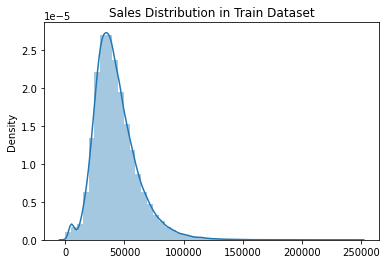

In [316]:
sns.distplot(x = train['Sales'])
plt.title('Sales Distribution in Train Dataset')
plt.show()

In [306]:
#Creating time features here
def timeFeatures(df):
    # Derive new features using the click_time column
    df['Date'] = pd.to_datetime(df['Date'])
    df['day_of_week'] = df['Date'].dt.dayofweek.astype('object')
    df["day_of_year"] = df['Date'].dt.dayofyear.astype('object')
    df["month"] = df["Date"].dt.month.astype('object')
    return df

train = timeFeatures(train)
test = timeFeatures(test)

train = train.drop(columns=['Date'])
test = test.drop(columns=['Date'])

In [307]:
train['Store_id'] = train['Store_id'].astype('object') #id and holiday is not continous so making it catgorical 
train['Holiday'] = train['Holiday'].astype('object')

In [308]:
train['Sales'] = train['Sales'].apply(lambda x:round(x,2)) #making sure sales price is of format xxxxx.xx only

In [309]:
#Though all features are catgorical still keeping them in single list so further processing is little easy

num_feats = train.drop(columns=['#Order','Sales',"ID"]).select_dtypes(include='number').columns.tolist()
cat_feats = train.drop(columns=['Sales']).select_dtypes(include='object').columns.tolist()
feats = num_feats+cat_feats
target = 'Sales'
print(num_feats)
print(cat_feats)

[]
['ID', 'Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Holiday', 'Discount', 'day_of_week', 'day_of_year', 'month']


In [310]:
train.info() #after processing looking at dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  object 
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Holiday        188340 non-null  object 
 6   Discount       188340 non-null  object 
 7   #Order         188340 non-null  int64  
 8   Sales          188340 non-null  float64
 9   day_of_week    188340 non-null  object 
 10  day_of_year    188340 non-null  object 
 11  month          188340 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 17.2+ MB


In [190]:
#checking if there is any mismatch of train and test catgories

for each in train[cat_feats].columns:
   print('train column', each, 'values',len(train[each].unique()))
   print('test column', each, 'values', len(test[each].unique()))
   print('train and test catg matches', len(train[~train[each].isin(test[each].unique())][each])) # zero means all catg are present in train which are in test
   print('test and train catg matches', len(test[~test[each].isin(train[each].unique())][each]))  # zero means all catg are present in train which are in test
   print('---------------------------------------------------')

train column ID values 188340
test column ID values 22265
train and test catg matches 188340
test and train catg matches 22265
---------------------------------------------------
train column Store_id values 365
test column Store_id values 365
train and test catg matches 0
test and train catg matches 0
---------------------------------------------------
train column Store_Type values 4
test column Store_Type values 4
train and test catg matches 0
test and train catg matches 0
---------------------------------------------------
train column Location_Type values 5
test column Location_Type values 5
train and test catg matches 0
test and train catg matches 0
---------------------------------------------------
train column Region_Code values 4
test column Region_Code values 4
train and test catg matches 0
test and train catg matches 0
---------------------------------------------------
train column Holiday values 2
test column Holiday values 2
train and test catg matches 0
test and train c

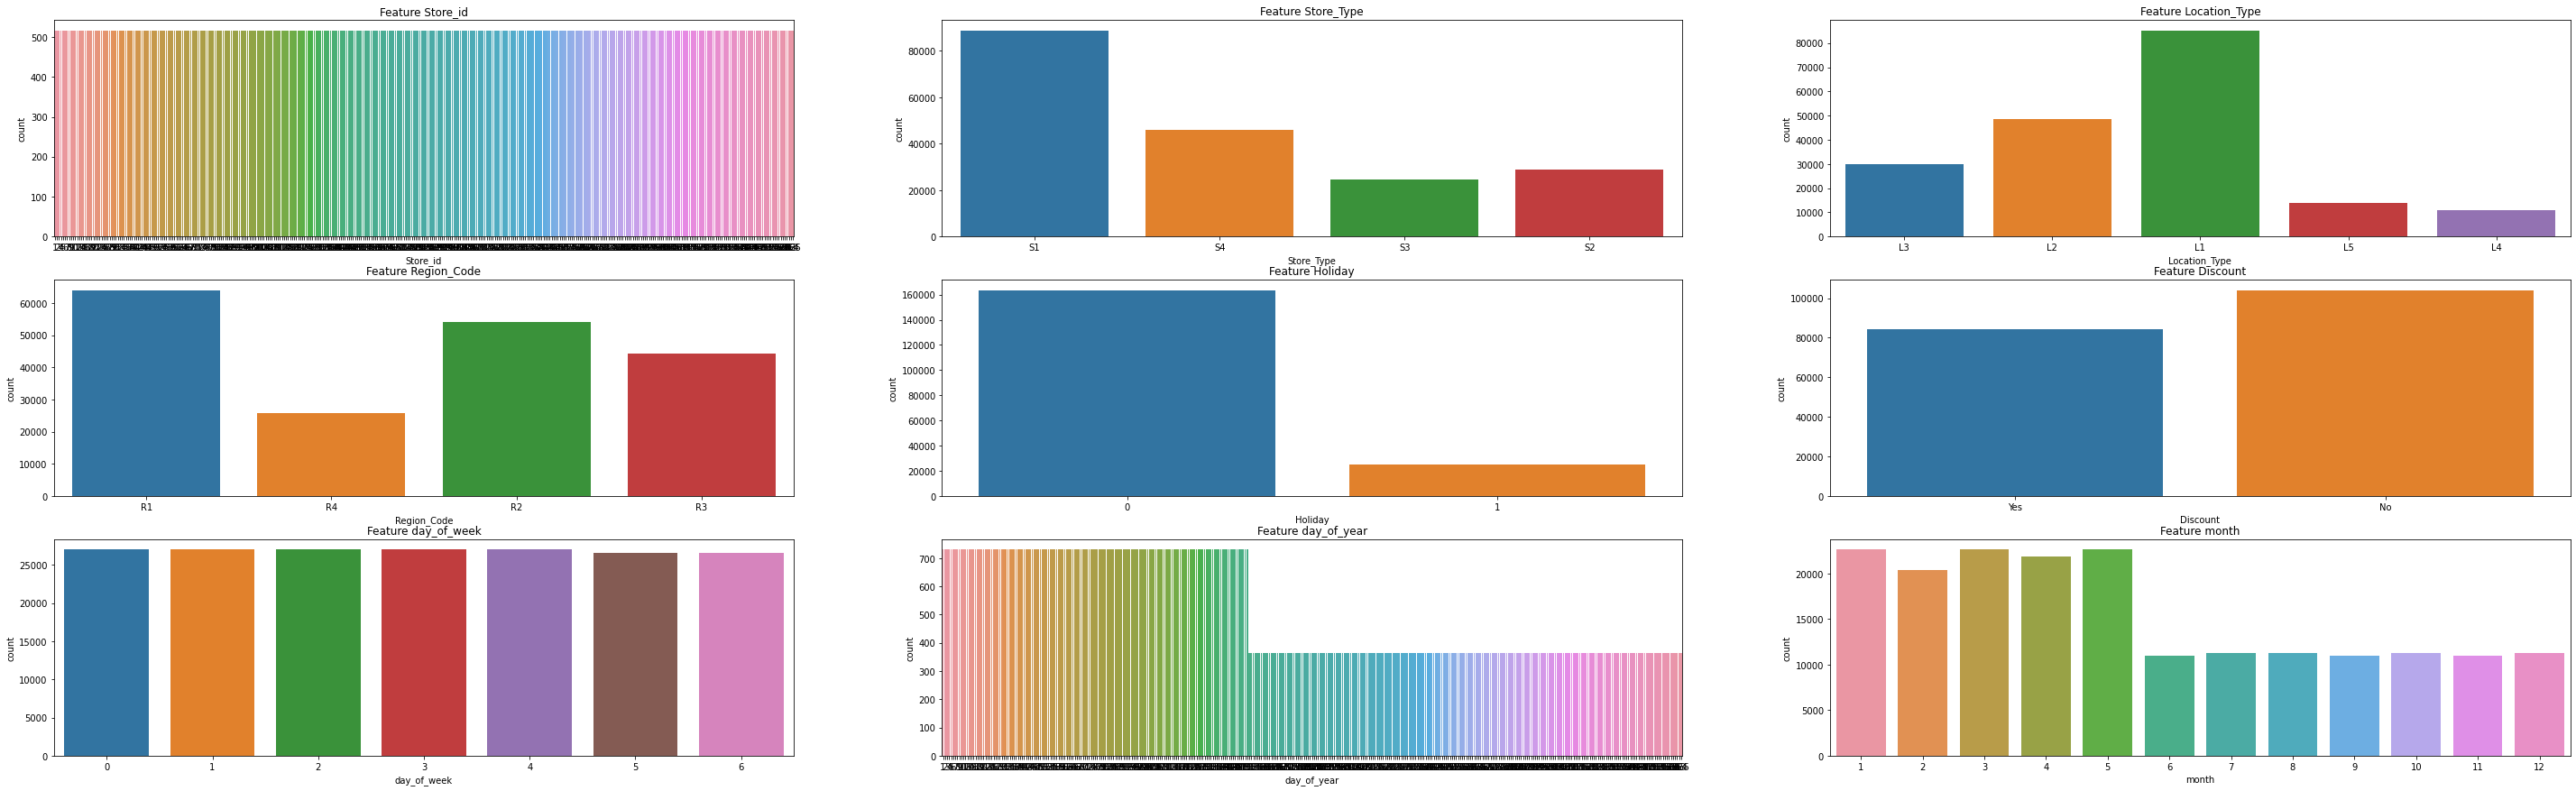

In [319]:
#Observing catg features distribution
plt.figure(figsize=(50, 15))  
plt.subplot(3,3,1)
plt.title('Feature Store_id')
sns.countplot(train['Store_id'])

plt.subplot(3,3,2)
plt.title('Feature Store_Type')
sns.countplot(train['Store_Type'])

plt.subplot(3,3,3)
plt.title('Feature Location_Type')
sns.countplot(train['Location_Type'])

plt.subplot(3,3,4)
plt.title('Feature Region_Code')
sns.countplot(train['Region_Code'])

plt.subplot(3,3,5)
plt.title('Feature Holiday')
sns.countplot(train['Holiday'])

plt.subplot(3,3,6)
plt.title('Feature Discount')
sns.countplot(train['Discount'])

plt.subplot(3,3,7)
plt.title('Feature day_of_week')
sns.countplot(train['day_of_week'])

plt.subplot(3,3,8)
plt.title('Feature day_of_year')
sns.countplot(train['day_of_year'])

plt.subplot(3,3,9)
plt.title('Feature month')
sns.countplot(train['month'])
plt.show() 

In [311]:
train[cat_feats].describe() #checking the basic details of our features

,ID,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,day_of_week,day_of_year,month
count,188340,188340,188340,188340,188340,188340,188340,188340,188340,188340
unique,188340,365,4,5,4,2,2,7,365,12
top,T1092501,365,S1,L1,R1,0,No,4,1,5
freq,1,516,88752,85140,63984,163520,104051,27010,730,22630


In [191]:
train.head() #after processing loooking at data again

,ID,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,#Order,Sales,day_of_week,day_of_year,month
0,T1000001,1,S1,L3,R1,1,Yes,9,7011.84,0,1,1
1,T1000002,253,S4,L2,R1,1,Yes,60,51789.12,0,1,1
2,T1000003,252,S3,L2,R1,1,Yes,42,36868.20,0,1,1
3,T1000004,251,S2,L3,R1,1,Yes,23,19715.16,0,1,1
4,T1000005,250,S2,L3,R4,1,Yes,62,45614.52,0,1,1


## Data Pre Processing 

Here pandas dummies feature is used for creating new useful features from catgorical variables. 

Dummy Feature: Convert categorical variable into dummy/indicator variables

In [192]:
for each in ['Store_Type','Location_Type','Region_Code','Discount']:
    dummiesList = pd.get_dummies(train[each],drop_first=True)
    train = pd.concat([train, dummiesList], axis = 1)
    train= train.drop(columns=[each])
    print(each,train.shape)

    dummiesList = pd.get_dummies(test[each],drop_first=True)
    test = pd.concat([test, dummiesList], axis = 1)
    test= test.drop(columns=[each])
    print(each,test.shape)

Store_Type (188340, 14)
Store_Type (22265, 12)
Location_Type (188340, 17)
Location_Type (22265, 15)
Region_Code (188340, 19)
Region_Code (22265, 17)
Discount (188340, 19)
Discount (22265, 17)


In [193]:
train.shape, test.shape

((188340, 19), (22265, 17))

In [194]:
train.head()

,ID,Store_id,Holiday,#Order,Sales,day_of_week,day_of_year,month,S2,S3,S4,L2,L3,L4,L5,R2,R3,R4,Yes
0,T1000001,1,1,9,7011.84,0,1,1,0,0,0,0,1,0,0,0,0,0,1
1,T1000002,253,1,60,51789.12,0,1,1,0,0,1,1,0,0,0,0,0,0,1
2,T1000003,252,1,42,36868.20,0,1,1,0,1,0,1,0,0,0,0,0,0,1
3,T1000004,251,1,23,19715.16,0,1,1,1,0,0,0,1,0,0,0,0,0,1
4,T1000005,250,1,62,45614.52,0,1,1,1,0,0,0,1,0,0,0,0,1,1


In [195]:
test.head()

,ID,Store_id,Holiday,day_of_week,day_of_year,month,S2,S3,S4,L2,L3,L4,L5,R2,R3,R4,Yes
0,T1188341,171,0,5,152,6,0,0,1,1,0,0,0,0,1,0,0
1,T1188342,172,0,5,152,6,0,0,0,0,0,0,0,0,0,0,0
2,T1188343,173,0,5,152,6,0,0,1,1,0,0,0,0,0,0,0
3,T1188344,174,0,5,152,6,0,0,0,0,0,0,0,0,0,1,0
4,T1188345,170,0,5,152,6,0,0,0,0,0,0,0,1,0,0,0


splitiing data for test and train for validation purpose

In [196]:
from sklearn.model_selection import train_test_split

# create x and y train
X = train.drop(columns=['#Order','Sales','ID'], axis=1)
y = train[['Sales']]

X_test = test.drop(columns=['ID'], axis=1)

np.random.seed(0)# split data into train and test/validation sets

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2,random_state=41,)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, X_test.shape

((150672, 16), (37668, 16), (150672, 1), (37668, 1), (22265, 16))

In [197]:
X_test.head()

,Store_id,Holiday,day_of_week,day_of_year,month,S2,S3,S4,L2,L3,L4,L5,R2,R3,R4,Yes
0,171,0,5,152,6,0,0,1,1,0,0,0,0,1,0,0
1,172,0,5,152,6,0,0,0,0,0,0,0,0,0,0,0
2,173,0,5,152,6,0,0,1,1,0,0,0,0,0,0,0
3,174,0,5,152,6,0,0,0,0,0,0,0,0,0,1,0
4,170,0,5,152,6,0,0,0,0,0,0,0,1,0,0,0


In [198]:
X_train.head()

,Store_id,Holiday,day_of_week,day_of_year,month,S2,S3,S4,L2,L3,L4,L5,R2,R3,R4,Yes
11566,164,0,3,32,2,0,0,0,0,0,0,0,0,1,0,0
62376,250,0,2,171,6,1,0,0,0,1,0,0,0,0,1,1
176766,189,0,1,120,4,1,0,0,0,1,0,0,0,1,0,1
4659,321,0,5,13,1,0,1,0,0,0,0,0,1,0,0,1
82476,279,0,1,226,8,1,0,0,0,1,0,0,1,0,0,0


In [313]:
#for memory saving, changing dtype
X_train = X_train.astype('uint8')
X_valid = X_valid.astype('uint8')
X_test = X_test.astype('uint8')

In [200]:
#inital dataframes for predictions which will help us to perform actions easily. 

pred = pd.DataFrame()
valid_pred = pd.DataFrame()

## Random Forest

In [201]:
%%time
#training the rfc model
rfc=  RandomForestRegressor(random_state=42)
rfc.fit(X_train,y_train)

valid_pred['rfc'] = rfc.predict(X_valid)
valid_pred['rfc'] = valid_pred['rfc'].apply(lambda x:round(x,2))

pred['rfc'] = rfc.predict(X_test)
pred['rfc'] = pred['rfc'].apply(lambda x:round(x,2))

print('r2_score',r2_score(y_valid,valid_pred))
print('mean_squared_log_error',mean_squared_log_error(y_valid, valid_pred)*1000)

r2_score 0.7645871631685298
mean_squared_log_error 54.124802778600916
CPU times: user 54.8 s, sys: 167 ms, total: 55 s
Wall time: 54.9 s


Text(0.5, 1.0, 'Feature Importance with RFC')

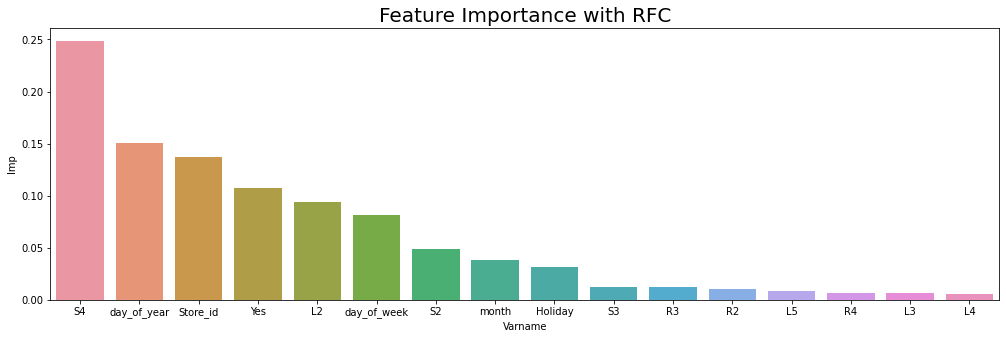

In [287]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rfc.feature_importances_}).sort_values(by="Imp", ascending=False)
    
from matplotlib import pyplot
a4_dims = (17, 5)
fig, ax = pyplot.subplots(figsize=a4_dims)

sns.barplot(x='Varname',y='Imp', data=imp_df,ax=ax)
plt.title('Feature Importance with RFC', fontsize=20)

## XGB

In [203]:
%%time
#training the xgb model
xgb = XGBRegressor(random_state=42)                
xgb.fit(X_train, y_train)

valid_pred['xgb'] = xgb.predict(X_valid)
valid_pred['xgb'] = valid_pred['xgb'].apply(lambda x:round(x,2))

pred['xgb'] = xgb.predict(X_test)
pred['xgb'] = pred['xgb'].apply(lambda x:round(x,2))

print('r2_score',r2_score(y_valid,valid_pred['xgb']))
print('mean_squared_log_error',mean_squared_log_error(y_valid, valid_pred['xgb'])*1000)

[11:24:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
r2_score 0.6671841608729041
mean_squared_log_error 88.94995870223013
CPU times: user 8.87 s, sys: 18.3 ms, total: 8.89 s
Wall time: 8.86 s


Text(0.5, 1.0, 'Feature Importance with XGB')

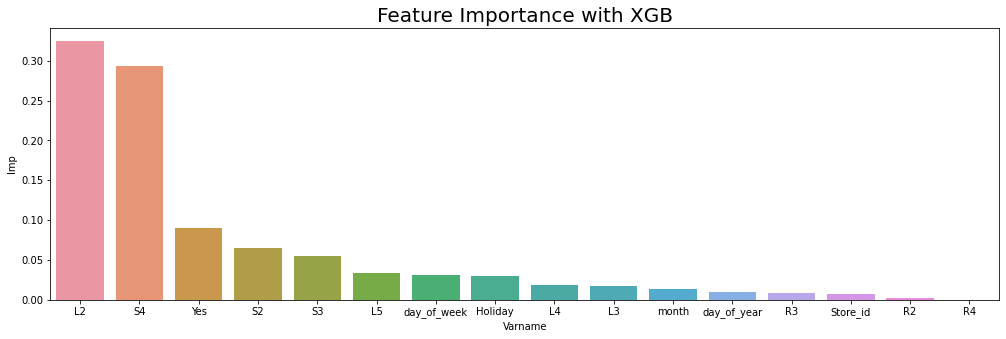

In [291]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": xgb.feature_importances_}).sort_values(by="Imp", ascending=False)
    
from matplotlib import pyplot
a4_dims = (17, 5)
fig, ax = pyplot.subplots(figsize=a4_dims)

sns.barplot(x='Varname',y='Imp', data=imp_df,ax=ax)
plt.title('Feature Importance with XGB', fontsize=20)

## LGBM

In [265]:
%%time
#training the lgbm model
#Converting the dataset in proper LGB format
d_train=lgb.Dataset(X_train, label=y_train)
d_eval=lgb.Dataset(X_valid, label=y_valid)

#setting up the parameters
params={}
params['learning_rate']=0.01
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='regression' #Regression target feature
params['metric']='mse' #metric for regression 

lgbm=lgb.train(params,num_boost_round=100000, train_set=d_train,
                          valid_sets=d_eval,verbose_eval=1000,
                          early_stopping_rounds=200,)  #training the model on 10 epocs

Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l2: 7.63853e+07
[2000]	valid_0's l2: 6.75988e+07
[3000]	valid_0's l2: 6.35173e+07
[4000]	valid_0's l2: 6.05759e+07
[5000]	valid_0's l2: 5.86642e+07
[6000]	valid_0's l2: 5.71526e+07
[7000]	valid_0's l2: 5.60098e+07
[8000]	valid_0's l2: 5.49086e+07
[9000]	valid_0's l2: 5.39596e+07
[10000]	valid_0's l2: 5.31614e+07
[11000]	valid_0's l2: 5.23934e+07
[12000]	valid_0's l2: 5.17538e+07
[13000]	valid_0's l2: 5.11314e+07
[14000]	valid_0's l2: 5.05535e+07
[15000]	valid_0's l2: 5.00845e+07
[16000]	valid_0's l2: 4.95941e+07
[17000]	valid_0's l2: 4.91322e+07
[18000]	valid_0's l2: 4.86945e+07
[19000]	valid_0's l2: 4.825e+07
[20000]	valid_0's l2: 4.78315e+07
[21000]	valid_0's l2: 4.7435e+07
[22000]	valid_0's l2: 4.70977e+07
[23000]	valid_0's l2: 4.68076e+07
[24000]	valid_0's l2: 4.65113e+07
[25000]	valid_0's l2: 4.6214e+07
[26000]	valid_0's l2: 4.59089e+07
[27000]	valid_0's l2: 4.56524e+07
[28000]	valid_0's l2: 4.53782e+0

In [266]:
valid_pred['lgbm']=lgbm.predict(X_valid)
valid_pred['lgbm'] = xgb.predict(X_valid)
valid_pred['lgbm'] = valid_pred['lgbm'].apply(lambda x:round(x,2))

pred['lgbm'] = xgb.predict(X_test)
pred['lgbm'] = pred['lgbm'].apply(lambda x:round(x,2))

print('r2_score',r2_score(y_valid,valid_pred['lgbm']))
print('mean_squared_log_error',mean_squared_log_error(y_valid, valid_pred['lgbm'])*1000)

r2_score 0.6671841608729041
mean_squared_log_error 88.94995870223013


## Ensemble of Models

Different weightage is given to xgb, rfc and lgbm poredictions because error on lgbm<xgb<rfc

- lgbm weightage  = 3
- xgb weightage = 2
- rfc weightage = 1

In [281]:
#Checking on validation datasets
valid_pred['ensemble'] = round((2*valid_pred['xgb'] + valid_pred['rfc']+3*valid_pred['lgbm'])/6,2)
print('r2_score',r2_score(y_valid,valid_pred['ensemble']))
print('mean_squared_log_error',mean_squared_log_error(y_valid, valid_pred['ensemble'])*1000)

r2_score 0.7078360116828539
mean_squared_log_error 79.86125886359228


In [314]:
#ensembing for test dataset and for final submisson on platform
pred['ensemble'] = round((2*pred['xgb'] + pred['rfc']+3*pred['lgbm'])/6,2)

## Submisson Creation

In [276]:
sub = pd.read_csv('/content/drive/MyDrive/JOB-A-THON - September 2021/SAMPLE.csv', index_col=0) #reading submission file
sub.head()

,Sales
ID,
T1188341,42275
T1188342,42275
T1188343,42275
T1188344,42275
T1188345,42275


In [277]:
sub['Sales'] = pred['ensemble'].values #overwriting our predicted sales values 
sub.head()

,Sales
ID,
T1188341,66030.30
T1188342,39222.99
T1188343,71463.60
T1188344,39686.42
T1188345,39324.72


In [278]:
sub.to_csv('/content/drive/MyDrive/JOB-A-THON - September 2021/sub_final_ensemble.csv', index_label='ID') #finally saving our ensemble predictions into submission csv